0# Udacity - Machine Learning Engineer Nanodegree
## Capstone Project
### Title: Development of a LSTM Network to Predict Students’ Answers on Exam Questions

IMPORTS

In [1]:
import deepkt
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as ac; ac.set_theme()
import scipy.stats as st
from sci_analysis import analyze
import pandas as pd
import bnlearn as bn
from scipy.special import expit
import matplotlib
import pgmpy

In [36]:
an = "data/2015_100_skill_builders_main_problems.csv"
df = pd.read_csv ('data/2015_100_skill_builders_main_problems.csv')
df["correct"]= np.where(df["old"]>0.5, 1,0)
df.to_csv('data/2015_100_skill_builders_main_problems.csv')

print(df)



        user_id     log_id  skill_id       old  correct
0         50121  167478035      7014  0.000000        0
1         50121  167478043      7014  1.000000        1
2         50121  167478053      7014  1.000000        1
3         50121  167478069      7014  1.000000        1
4         50964  167478041      7014  1.000000        1
...         ...        ...       ...       ...      ...
708626   362374  175292695     31260  0.666667        1
708627   362374  175293309     31260  0.666667        1
708628   362374  175293826     31260  1.000000        1
708629   362374  175294002     31260  1.000000        1
708630   362374  175294060     31260  1.000000        1

[708631 rows x 5 columns]


### Implementation of DKT:
#### Part 1: Define constants

In [55]:
 # Dataset path
fn = "data/2015_100_skill_builders_main_problems.csv"
verbose = 1 # Verbose = {0,1,2}
best_model_weights = "weights/bestmodel" # File to save the model.
log_dir = "logs" # Path to save the logs.
optimizer = "adam" # Optimizer to use
lstm_units = 110 # Number of LSTM units
batch_size = 32 # Batch size
epochs = 20 # Number of epochs to train
dropout_rate = 0.4 # Dropout rate
test_fraction = 0.2 # Portion of data to be used for testing
validation_fraction = 0.2 # Portion of training data to be used for validation

#### Part 2: Pre-processing

In [56]:
from deepkt import deepkt, data_util, metrics


dataset, length, nb_features, nb_skills = data_util.load_dataset(fn=fn,
                                                                 batch_size=batch_size,
                                                                 shuffle=True)

train_set, test_set, val_set = data_util.split_dataset(dataset=dataset,
                                                       total_size=length,
                                                       test_fraction=test_fraction,
                                                       val_fraction=validation_fraction)


set_sz = length * batch_size
test_set_sz = (set_sz * test_fraction)
val_set_sz = (set_sz - test_set_sz) * validation_fraction
train_set_sz = set_sz - test_set_sz - val_set_sz
print("============= Data Summary =============")
print("Total number of students: %d" % set_sz)
print("Training set size: %d" % train_set_sz)
print("Validation set size: %d" % val_set_sz)
print("Testing set size: %d" % test_set_sz)
print("Number of skills: %d" % nb_skills)
print("Number of features in the input: %d" % nb_features)
print("========================================")

============= Data Summary =============
Total number of students: 19424
Training set size: 12431
Validation set size: 3107
Testing set size: 3884
Number of skills: 100
Number of features in the input: 200


#### Part 3: Building the model

In [57]:
#batch_size=1

train_length=train_set_sz // batch_size
val_length=val_set_sz // batch_size

student_model = deepkt.DKTModel(
                        nb_features=nb_features,
                        nb_skills=nb_skills,
                        hidden_units=lstm_units,
                        dropout_rate=dropout_rate)

student_model.compile(
        optimizer=optimizer,
        metrics=[
            metrics.BinaryAccuracy(),
            metrics.AUC(),
            metrics.Precision(),
            metrics.Recall()
        ])

student_model.summary()

Model: "DKTModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, None, 200)]       0         
_________________________________________________________________
masking_1 (Masking)          (None, None, 200)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 110)         136840    
_________________________________________________________________
outputs (TimeDistributed)    (None, None, 100)         11100     
Total params: 147,940
Trainable params: 147,940
Non-trainable params: 0
_________________________________________________________________


#### Part 4: Train the Model

In [58]:
import tensorflow as tf
history = student_model.fit(dataset=train_set,
                            epochs=epochs,
                            verbose=verbose,
                            validation_data=val_set,
                            callbacks=[ 
                                tf.keras.callbacks.CSVLogger(f"{log_dir}/train.log"),
                                tf.keras.callbacks.ModelCheckpoint(best_model_weights,
                                                                   save_best_only=True,
                                                                   save_weights_only=True),
                                tf.keras.callbacks.TensorBoard(log_dir=log_dir)
        ])

Epoch 1/20


2022-05-01 12:45:47.296956: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_18092_18689' and '__inference___backward_standard_lstm_18092_18689_specialized_for_training_1_Adam_gradients_gradients_lstm_1_StatefulPartitionedCall_grad_StatefulPartitionedCall_at___inference_keras_scratch_graph_19341' both implement 'lstm_11f472e9-584c-4b69-b11d-adc143e7bd13' but their signatures do not match.


      1/Unknown - 4s 4s/step - loss: 0.1102 - binary_accuracy: 0.5199 - auc_1: 0.4626 - precision_1: 0.6947 - recall_1: 0.5869

2022-05-01 12:45:48.048685: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


388/388 [==============================] - 91s 235ms/step - loss: 0.1257 - binary_accuracy: 0.7283 - auc_1: 0.6190 - precision_1: 0.7372 - recall_1: 0.9768 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/20
388/388 [==============================] - 85s 220ms/step - loss: 0.1227 - binary_accuracy: 0.7399 - auc_1: 0.6774 - precision_1: 0.7488 - recall_1: 0.9704 - val_loss: 0.1200 - val_binary_accuracy: 0.7440 - val_auc_1: 0.6972 - val_precision_1: 0.7569 - val_recall_1: 0.9593
Epoch 3/20
388/388 [==============================] - 88s 228ms/step - loss: 0.1188 - binary_accuracy: 0.7428 - auc_1: 0.6932 - precision_1: 0.7539 - recall_1: 0.9635 - val_loss: 0.1133 - val_binary_accuracy: 0.7465 - val_auc_1: 0.7104 - val_precision_1: 0.7510 - val_recall_1: 0.9783
Epoch 4/20
388/388 [==============================] - 78s 200ms/step - loss: 0.1185 - binary_accuracy: 0.7433 - auc_1: 0.6989 - precisio

In [ ]:
# import tensorflow as tf
# history = student_model.fit(dataset=train_set.repeat(),
#                             epochs=epochs,
#                             verbose=verbose,
#                             validation_data=val_set,
#                             steps_per_epoch=train_length,
#                             validation_steps=val_length,
#                             callbacks=[
#                                 tf.keras.callbacks.CSVLogger(f"{log_dir}/train.log"),
#                                 tf.keras.callbacks.ModelCheckpoint(best_model_weights,
#                                                                    save_best_only=True,
#                                                                    save_weights_only=True),
#                                 tf.keras.callbacks.TensorBoard(log_dir=log_dir)
#         ]
#                             )

#### Part 5: Load the Model with the Best Validation Loss

In [64]:
student_model.load_weights(best_model_weights)

#### Part 6: Test the Model

In [65]:
result = student_model.evaluate(test_set, verbose=verbose)

    122/Unknown - 12s 99ms/step - loss: 0.1132 - binary_accuracy: 0.7503 - auc_1: 0.7264 - precision_1: 0.7594 - recall_1: 0.9641

#### Take One Sample

In [93]:
def get_element_by_index(data_set,candidate_index):
    """
    This function gets candidate
    by index
    """
    for raw_index,candidate in enumerate(data_set):
        if raw_index == candidate_index:
            candidate_desired = candidate
            return candidate_desired

student_desired=get_element_by_index(test_set,700)
print(student_desired[0][0][1])

TypeError: 'NoneType' object is not subscriptable

#### Part 8: Experiment on tf.expand_dims

In [66]:
student_prediction=tf.expand_dims(student_desired[0], axis=0)

NameError: name 'student_desired' is not defined

In [67]:
sample1=np.zeros((1,100,200))#change here for 2009

In [68]:
for i in range(100):
    sample1[0][i][2*i+1]=1

In [69]:
from tensorflow_core import float32


predictedTensor=tf.convert_to_tensor(sample1,dtype=float32)

#### Part 9: Predict only one student from Desired Data Set

In [70]:
prediction_of_one_student.shape

(123, 123)

In [71]:
student_prediction=tf.expand_dims(predictedTensor, axis=0)

In [72]:
prediction_of_one_student=student_model.predict(tf.squeeze(student_prediction,axis=0))[0]
print(prediction_of_one_student.shape) #This is how the prediction output looks like
print(tf.squeeze(student_prediction,axis=0).shape)#this is how the input looks like see paper intuition doubling the skill_size
prediction_of_one_student[114] #prediction of last time step

(100, 100)
(1, 100, 200)


IndexError: index 114 is out of bounds for axis 0 with size 100

In [73]:
count=100
averages=[]

for i in range (count):
    suma = 0
    for j in range(count):
        suma += prediction_of_one_student[i][j]
    averages.append(suma/count)

In [74]:
relationships = []
for i in range (count):
    relationship = []
    for j in range(count):
        relationship.append(prediction_of_one_student[i][j]/averages[i])
    relationships.append(relationship)

print(len(relationships))
print(len(relationships[0]))

100
100


In [75]:
df = pd.DataFrame(relationships, columns=[i for i in range(100)])

In [76]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.068345,1.040982,0.832960,1.106039,0.975467,1.214644,0.898861,0.818454,0.949138,0.955375,...,0.960094,1.050587,0.929380,0.882661,1.029063,0.896548,1.085141,1.036949,0.673347,0.875495
1,0.948008,1.131836,0.798682,1.133444,0.981179,1.245664,0.901863,0.739570,0.904673,0.933531,...,0.985554,1.100311,0.962271,0.883917,1.037016,0.858318,1.103374,1.056391,0.563158,0.781053
2,0.962601,1.087174,0.968669,1.115423,1.002694,1.217123,0.943973,0.761178,0.889098,0.932294,...,0.948742,1.133958,0.985956,0.925330,1.039242,0.818137,1.093405,1.043078,0.536570,0.776659
3,0.942234,1.060991,0.901738,1.154064,0.997016,1.220186,0.963888,0.773595,0.889257,0.944109,...,0.981864,1.131911,0.968736,0.913845,1.054825,0.845073,1.068571,1.021406,0.520027,0.762446
4,0.921719,1.047234,0.912163,1.169759,1.043633,1.209286,0.958797,0.789999,0.870221,0.980002,...,0.988514,1.109596,0.929606,0.898687,1.030213,0.820845,1.071640,1.009794,0.550181,0.746763


In [77]:
corr = df.corr()

In [78]:
corr

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,0.131174,0.549706,-0.441372,-0.156160,-0.350425,-0.365436,-0.098604,0.081547,-0.000182,...,-0.650736,0.348055,0.190586,0.696762,0.816744,0.257535,-0.013536,-0.293862,-0.135694,0.587804
1,0.131174,1.000000,-0.329388,0.522053,0.351508,0.055958,-0.540975,-0.479354,-0.632625,-0.385677,...,0.156758,0.516056,-0.211925,-0.069206,0.224943,0.230811,0.236138,-0.350629,0.309295,-0.051118
2,0.549706,-0.329388,1.000000,-0.640719,-0.539249,-0.092233,0.128965,0.051375,0.182751,0.040472,...,-0.597711,0.142684,0.114491,0.481206,0.328643,-0.036923,-0.267016,0.203650,-0.520956,0.287001
3,-0.441372,0.522053,-0.640719,1.000000,0.772589,0.441081,-0.383995,-0.449311,-0.616200,-0.108167,...,0.417489,0.044653,-0.577060,-0.436045,-0.161592,-0.302100,0.539632,-0.206051,0.157907,-0.573632
4,-0.156160,0.351508,-0.539249,0.772589,1.000000,0.201630,-0.461348,-0.395026,-0.558801,-0.085330,...,0.209730,0.046998,-0.427101,-0.032089,0.068313,-0.327416,0.659723,-0.254270,0.096842,-0.357268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.257535,0.230811,-0.036923,-0.302100,-0.327416,-0.696337,0.157545,0.517110,0.263671,-0.198884,...,0.124277,0.379473,0.450632,0.125674,0.395404,1.000000,-0.748179,-0.442109,0.681588,0.231212
96,-0.013536,0.236138,-0.267016,0.539632,0.659723,0.572410,-0.597255,-0.717425,-0.462374,0.152776,...,-0.112933,-0.129984,-0.454427,0.022258,-0.065174,-0.748179,1.000000,0.120370,-0.442087,-0.116700
97,-0.293862,-0.350629,0.203650,-0.206051,-0.254270,0.431614,0.008955,-0.123308,0.166170,0.053032,...,-0.157425,-0.476429,-0.177707,-0.177191,-0.546106,-0.442109,0.120370,1.000000,-0.520502,-0.239875
98,-0.135694,0.309295,-0.520956,0.157907,0.096842,-0.542866,0.209487,0.383728,0.013005,-0.070236,...,0.340258,0.139302,0.354510,-0.265745,0.130215,0.681588,-0.442087,-0.520502,1.000000,0.013680


In [79]:
links = corr.stack().reset_index()
links.columns = ['var1', 'var2','value']

In [88]:
links_filtered=links.loc[ (links['value'] > 0.8) & (links['var1'] != links['var2']) ]
links_filtered=links_filtered[links_filtered.var1.isnull() == False]
links_filtered=links_filtered[links_filtered.var2.isnull() == False]

links_filtered = links_filtered.sort_values(by=['value'],ascending=False)
links_filtered = links_filtered.groupby('var1').head(3)

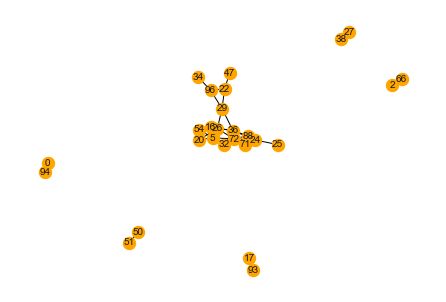

In [89]:
import networkx as nx

# Build your graph
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')
# Plot the network:
nx.draw(G, with_labels=True, node_color='orange', node_size=70, edge_color='black', linewidths=5, font_size=10,pos=nx.spring_layout(G))

#### Part 10: Show one student knowledge on all time_steps

In [65]:
#student_desired[0][0][3]
average_performance_of_each_concept=np.mean(prediction_of_one_student,axis=0)
average_performance_of_each_concept #average_performance of all time_steps

array([0.6954822 , 0.4564812 , 0.5423922 , 0.56853366, 0.6949309 ,
       0.6992768 , 0.7193209 , 0.6763963 , 0.65572995, 0.6319698 ,
       0.8694718 , 0.73072594, 0.5053858 , 0.5765126 , 0.7899821 ,
       0.5898231 , 0.70796835, 0.8460827 , 0.8044082 , 0.7652495 ,
       0.5721069 , 0.89752704, 0.5436952 , 0.5431869 , 0.5053491 ,
       0.6651835 , 0.6141199 , 0.64489836, 0.38807914, 0.6135989 ,
       0.7048147 , 0.62349415, 0.71506906, 0.8127527 , 0.73477566,
       0.7161563 , 0.7144337 , 0.7131349 , 0.608767  , 0.7203267 ,
       0.77488995, 0.5848844 , 0.67769283, 0.41115412, 0.66282177,
       0.64058197, 0.7477688 , 0.3681304 , 0.50326353, 0.61882347,
       0.64083636, 0.49462032, 0.71923256, 0.5843102 , 0.69597125,
       0.7893062 , 0.75254095, 0.6161817 , 0.6144015 , 0.69273543,
       0.61317885, 0.5187306 , 0.5100732 , 0.55892587, 0.41817904,
       0.5333922 , 0.5783792 , 0.7516109 , 0.56144214, 0.44760984,
       0.45410505, 0.7410005 , 0.7475744 , 0.7558595 , 0.31840

#### Part 11: Prediction on Given Data Set

In [66]:
def prediction_on_given_data_set(d_set,prediction_set,student_answer_set):
    """
    This function makes prediction
    on given data set
    """
    for data_candidate in d_set:
        prediction_set.append(student_model.predict(data_candidate[0])[0])
        #set index 0 for 246,set 1 for 124
        temp=data_candidate[0]
        student_answer_set.append(temp[0])
    return prediction_set,student_answer_set

In [67]:
data_set_prediction=[]
data_set_student_answer=[]
data_set_prediction,data_set_student_answer=prediction_on_given_data_set(test_set,data_set_prediction,data_set_student_answer)
#data_set_prediction
#data_set_student_answer

In [73]:
#data_set_student_answer[0][0]
len(data_set_prediction)

810

#### Part 11: Extracting Concept Relations

In [69]:
def calculate_one_relation(nbr_skills1,prediction_test1,student_test1,rm1):
    """
    This function implements formula-1
    for one candidate
    """
    for i in range (nbr_skills1):
        for j in range (nbr_skills1) :
            if i != j :
                index1 = np.argwhere(student_test1==1)
                ax = np.argwhere(index1[:,1]==i*2+1)
                if len(ax) == 0:
                    indices = 0
                else :
                    indices = ax[0][0]
                rm1[i][j]+=(prediction_test1[indices][j]*student_test1[indices][i*2+1])/(np.sum(prediction_test1[indices])-prediction_test1[indices][j])
            else :
                rm1[i][j]=0
    return rm1
relation_matrix=np.zeros((nb_skills,nb_skills))

In [ ]:
formula_1=np.zeros((nb_skills,nb_skills))
for index,candidate_pred in enumerate(data_set_prediction):
    formula_1=calculate_one_relation(nb_skills,candidate_pred,data_set_student_answer[index],formula_1)
    print("##",index/len(data_set_prediction)*100)

In [ ]:
formula_1

In [109]:
def counter_nbr_of_student(nbr_skills1,student_test1,rm1,len1):
    """
    This function finds how many student answered skill n at least
    once correctly
    """
    for i in range (len1):
        for j in range (nbr_skills1) :
                index1 = np.argwhere(student_test1[i]==1)
                a_b = np.argwhere(index1[:,1]==j*2+1)
                if len(a_b) != 0:
                    rm1[j] =rm1[j]+1
    return rm1

In [140]:
#Calculates how many candidates answered skill n  correctly
counter_matrix=np.zeros(nb_skills)
counter_nbr_of_student(nb_skills,data_set_student_answer,counter_matrix,len(data_set_student_answer))
counter_matrix[counter_matrix==0]=-1
print(len(counter_matrix))

123


In [141]:
counter_matrix=counter_matrix.reshape(123,1)
print(counter_matrix)

[[138.]
 [219.]
 [103.]
 [ 90.]
 [105.]
 [162.]
 [262.]
 [233.]
 [179.]
 [199.]
 [197.]
 [212.]
 [102.]
 [104.]
 [190.]
 [103.]
 [106.]
 [169.]
 [155.]
 [ 48.]
 [135.]
 [125.]
 [144.]
 [ 91.]
 [198.]
 [105.]
 [108.]
 [110.]
 [ -1.]
 [123.]
 [372.]
 [197.]
 [391.]
 [375.]
 [146.]
 [ 60.]
 [107.]
 [324.]
 [257.]
 [ 77.]
 [153.]
 [113.]
 [264.]
 [ 23.]
 [365.]
 [314.]
 [121.]
 [189.]
 [270.]
 [239.]
 [ 36.]
 [189.]
 [ 93.]
 [ 57.]
 [ 46.]
 [326.]
 [201.]
 [ 95.]
 [134.]
 [153.]
 [118.]
 [ 43.]
 [ 45.]
 [127.]
 [ -1.]
 [  6.]
 [102.]
 [108.]
 [ 58.]
 [  9.]
 [ 63.]
 [ -1.]
 [ -1.]
 [ -1.]
 [ 10.]
 [ 25.]
 [ 18.]
 [ -1.]
 [163.]
 [283.]
 [254.]
 [283.]
 [286.]
 [ 31.]
 [  8.]
 [ 42.]
 [ 96.]
 [ 65.]
 [146.]
 [142.]
 [116.]
 [ 56.]
 [113.]
 [170.]
 [202.]
 [ 95.]
 [241.]
 [223.]
 [306.]
 [205.]
 [  1.]
 [ 85.]
 [  2.]
 [ 94.]
 [112.]
 [ -1.]
 [125.]
 [ -1.]
 [ -1.]
 [ -1.]
 [  1.]
 [ 11.]
 [ -1.]
 [ -1.]
 [ -1.]
 [  1.]
 [ -1.]
 [ 10.]
 [ -1.]
 [148.]
 [ -1.]
 [ 89.]
 [ -1.]]


In [ ]:
normalizeRelation_formula_1=formula_1/counter_matrix
print(normalizeRelation_formula_1)

In [ ]:
np.savetxt("test_set_relation_prediction_calculate_one_relation_normalized.csv",normalizeRelation_formula_1, delimiter=",")

In [77]:
def calculate_one_relation_improved(nbr_skills1,prediction_test1,student_test1,rm1):
    """
    This function implements formula-2
    for one candidate
    """
    for i in range (nbr_skills1):
        for j in range (nbr_skills1) :
                index1 = np.argwhere(student_test1==1)
                a_b = np.argwhere(index1[:,1]==i*2+1)
                if len(a_b) == 0:
                    rm1[i][j] = 0
                else :
                    indices = a_b[0][0]
                    rm1[i][j]=(prediction_test1[indices][j]*student_test1[indices][i*2+1])
    return rm1

In [89]:
# CALCULATING RELATION FOR ONE STUDENT
one_student=np.zeros((nb_skills,nb_skills))
one_student=calculate_one_relation_improved(nb_skills,data_set_prediction[0],data_set_student_answer[0],one_student)
print(one_student[one_student!=0])

[0.57752627 0.50702435 0.52225411 0.52268434 0.59546483 0.54896468
 0.586743   0.55154842 0.48287794 0.52175659 0.58043289 0.5448786
 0.49741817 0.47684222 0.57405531 0.50415289 0.52226561 0.59185892
 0.5404225  0.54112875 0.50622934 0.61287773 0.49089068 0.49104509
 0.47129631 0.51525354 0.51451087 0.51050854 0.46550569 0.5109818
 0.57178396 0.47519076 0.57143056 0.55650938 0.56387639 0.52393651
 0.55326873 0.53036624 0.51955712 0.52596945 0.55826592 0.51962519
 0.53099924 0.47402707 0.50858742 0.50649089 0.53567898 0.44523156
 0.47990471 0.50533873 0.50973064 0.4856497  0.54767781 0.48032892
 0.55084938 0.55192077 0.55055177 0.52110529 0.47258338 0.51867747
 0.53761959 0.5022859  0.51190907 0.52404439 0.48849452 0.49280554
 0.52299386 0.55650109 0.51343566 0.47208533 0.48461986 0.54646325
 0.55066442 0.54809958 0.48412201 0.48118943 0.49260512 0.53277093
 0.52443707 0.51879305 0.4895713  0.53921759 0.53724402 0.47422928
 0.42151901 0.52214646 0.48378804 0.5499106  0.54778695 0.519559

In [90]:
#FORMULA-2 DENOMINATOR
one_sum=one_student.sum(axis=0)
# print(one_sum)
x=one_student/one_sum
x[x!=0]

array([0.17435614, 0.24060518, 0.18566979, 0.19195372, 0.16725534,
       0.16936425, 0.192766  , 0.19305287, 0.24966477, 0.25022154,
       0.1647808 , 0.15781393, 0.20144458, 0.20972105, 0.1834923 ,
       0.2418469 , 0.23031088, 0.17240771, 0.20204746, 0.22901819,
       0.2470795 , 0.17110807, 0.22652355, 0.22786393, 0.31917774,
       0.20801288, 0.21053571, 0.20815035, 0.20703394, 0.20474425,
       0.19847123, 0.2783165 , 0.16359282, 0.16842486, 0.17567096,
       0.21020253, 0.18520563, 0.17907238, 0.21516539, 0.20731162,
       0.17846299, 0.22150038, 0.20860547, 0.24674306, 0.27666765,
       0.20400479, 0.19350568, 0.24276701, 0.2733034 , 0.26241812,
       0.20137624, 0.27129907, 0.18550245, 0.24037139, 0.16733241,
       0.18410135, 0.16551288, 0.22363962, 0.25290453, 0.2060634 ,
       0.22606562, 0.21612886, 0.1875138 , 0.19187369, 0.17287774,
       0.21884937, 0.18813815, 0.18491735, 0.19743735, 0.190446  ,
       0.19226274, 0.19181133, 0.19294425, 0.18135495, 0.23108

In [91]:
#CALCULATE FORMULA-2 FOR ALL CANDIDATES IN DATA
relation_matrix_improved=np.zeros((nb_skills,nb_skills))
relation_matrix_improved_v=np.zeros((nb_skills,nb_skills))
for index,candidate_pred in enumerate(data_set_prediction):
    relation_matrix_improved=calculate_one_relation_improved(nb_skills,candidate_pred,data_set_student_answer[index],
                                                             relation_matrix_improved)
    divide_vector = relation_matrix_improved.sum(axis=0)
    if 0 in divide_vector:
        divide_vector[divide_vector==0]=1
    relation_matrix_improved_v += relation_matrix_improved / divide_vector
    print("##",index/len(data_set_prediction)*100)

## 0.0
## 0.12345679012345678
## 0.24691358024691357
## 0.3703703703703704
## 0.49382716049382713
## 0.6172839506172839
## 0.7407407407407408
## 0.8641975308641975
## 0.9876543209876543
## 1.1111111111111112
## 1.2345679012345678
## 1.3580246913580247
## 1.4814814814814816
## 1.6049382716049383
## 1.728395061728395
## 1.8518518518518516
## 1.9753086419753085
## 2.0987654320987654
## 2.2222222222222223
## 2.345679012345679
## 2.4691358024691357
## 2.5925925925925926
## 2.7160493827160495
## 2.8395061728395063
## 2.9629629629629632
## 3.0864197530864197
## 3.2098765432098766
## 3.3333333333333335
## 3.45679012345679
## 3.580246913580247
## 3.7037037037037033
## 3.8271604938271606
## 3.950617283950617
## 4.074074074074074
## 4.197530864197531
## 4.320987654320987
## 4.444444444444445
## 4.567901234567901
## 4.691358024691358
## 4.814814814814815
## 4.938271604938271
## 5.061728395061729
## 5.185185185185185
## 5.3086419753086425
## 5.432098765432099
## 5.555555555555555
## 5.6790123456790

In [114]:
#PRINT RELATION MATRIX FOR FORMULA-2 WITHOUT NORMALIZATION
relation_matrix_improved_v


array([[ 3.77680027,  4.25135889,  3.69064131, ...,  4.14028267,
         3.71265451,  3.40814717],
       [12.42878287, 14.62805508, 12.96438048, ..., 13.98543655,
        13.25285189, 12.42387476],
       [ 1.45430941,  2.39124372,  2.04468969, ...,  1.79999023,
         1.4643537 ,  1.31434496],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.14322313,  2.04499821,  2.4111015 , ...,  2.36541069,
         2.52931812,  2.18537731],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [142]:
calculate_one_relation_improved_normalize=relation_matrix_improved_v/counter_matrix
calculate_one_relation_improved_normalize

array([[ 0.02736812,  0.03080695,  0.02674378, ...,  0.03000205,
         0.02690329,  0.02469672],
       [ 0.05675243,  0.06679477,  0.05919808, ...,  0.06386044,
         0.06051531,  0.05673002],
       [ 0.01411951,  0.02321596,  0.01985136, ...,  0.01747563,
         0.01421703,  0.01276063],
       ...,
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [ 0.02408116,  0.02297751,  0.02709103, ...,  0.02657765,
         0.0284193 ,  0.0245548 ],
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ]])

In [143]:
#SAVE RELATION MATRIX TO TXT
np.savetxt("calculate_one_relation_improved_normalize_test_set.csv", calculate_one_relation_improved_normalize, delimiter=",")

#### Part 12:Graphs of Relation Matrix

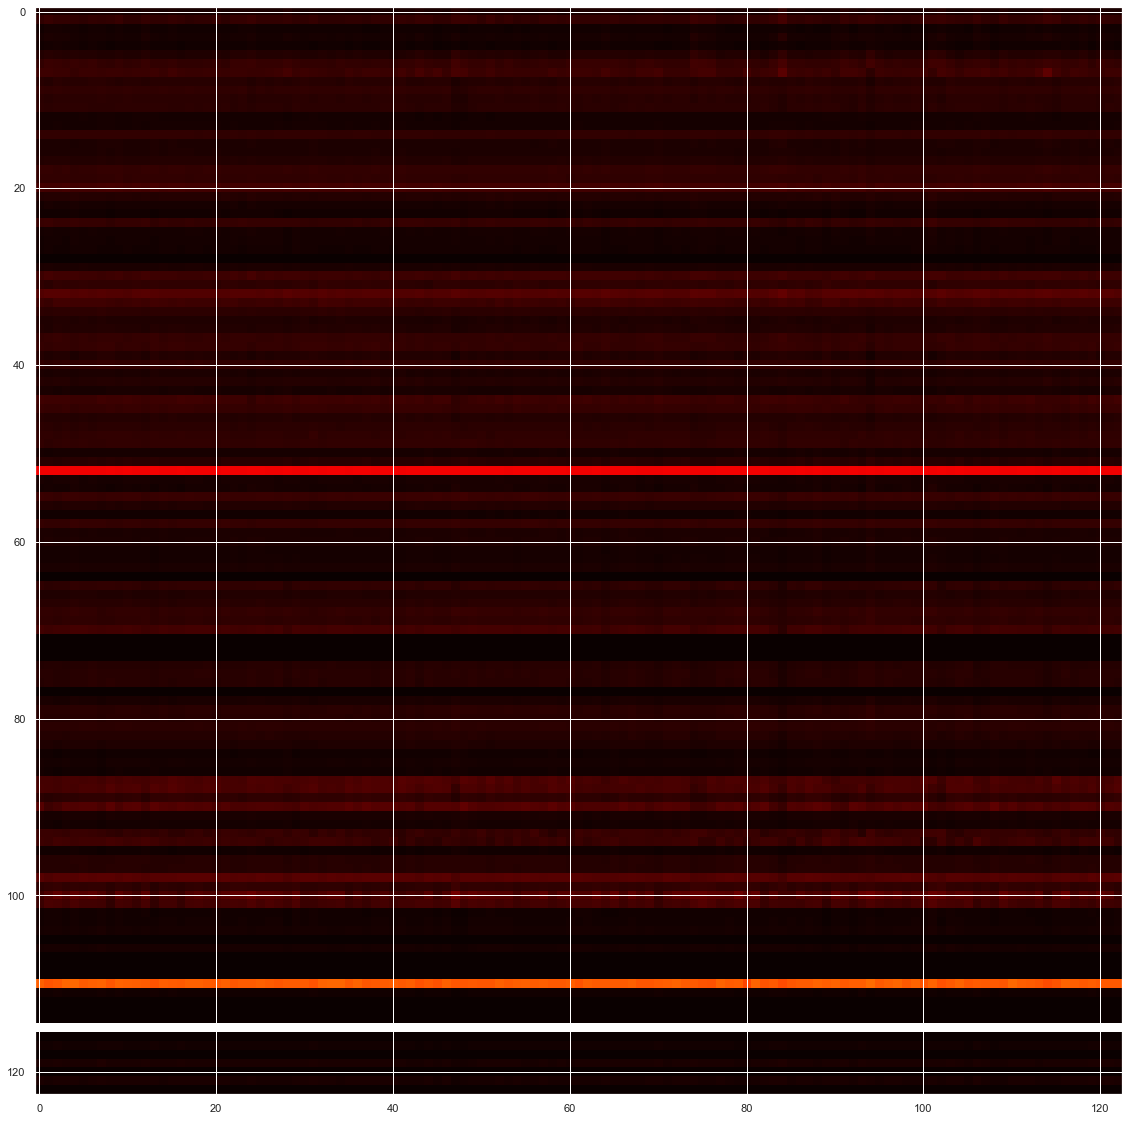

In [144]:
plt.figure(figsize = (20,20))
plt.imshow(calculate_one_relation_improved_normalize, cmap='hot', interpolation='nearest')
plt.show()

In [ ]:
ax = ac.heatmap(
    calculate_one_relation_improved_normalize,
    vmin=0, vmax=0.1, center=0,
    cmap=ac.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [145]:
cols=[]
for c  in range(123):
    strc="s"+ str(c)
    cols.append(strc)
index=[]
for m in range(123):
    stry="i" + str(m)
    index.append(stry)

In [146]:
calculate_one_relation_improved_normalize_frame = pd.DataFrame(data=calculate_one_relation_improved_normalize,index=index,
columns=cols)

In [101]:
#calculate_one_relation_improved_normalize_frame[calculate_one_relation_improved_normalize_frame < 0.1] = 0

In [157]:
calculate_one_relation_improved_normalize_frame.style.background_gradient(cmap='coolwarm')

In [ ]:
calculate_one_relation_improved_normalize_frame = pd.DataFrame(calculate_one_relation_improved_normalize,index=index,
columns=cols)
calculate_one_relation_improved_normalize_frame.style.background_gradient(cmap='coolwarm')

#### Bayesian Network Experiments

In [120]:
last_time_step_prediction_bayes=[]
#len(candidate)-1
for candidate in data_set_prediction:
    last_time_step_prediction_bayes.append(candidate[len(candidate)-1])

In [121]:
last_time_step_prediction_bayes=np.array(last_time_step_prediction_bayes)
last_time_step_prediction_bayes.shape

(810, 123)

In [123]:
last_time_step_prediction_bayes_th=np.where(last_time_step_prediction_bayes > 0.5, 1, 0)

In [125]:
last_time_step_prediction_bayes_th.shape

(810, 123)

In [126]:
last_time_step_prediction_bayes_th_df = pd.DataFrame(last_time_step_prediction_bayes_th,
columns=cols)

In [129]:
last_time_step_prediction_bayes_th_df.shape

(810, 123)

In [128]:
np.savetxt("last_time_step_prediction_bayes_th_df.csv",last_time_step_prediction_bayes_th_df, delimiter=",")

In [130]:
last_time_step_prediction_bayes_th_df

,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,...,s113,s114,s115,s116,s117,s118,s119,s120,s121,s122
0,1,0,1,1,1,1,1,1,0,0,...,0,0,0,1,0,1,1,1,1,0
1,1,0,1,1,1,1,1,1,0,1,...,0,0,0,1,1,0,1,0,1,1
2,1,0,1,1,1,1,1,1,0,0,...,0,0,0,1,0,0,1,1,0,1
3,1,0,1,1,1,1,1,1,0,1,...,0,0,0,1,1,1,1,1,0,1
4,1,1,1,1,1,1,1,1,1,1,...,0,0,0,1,1,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,1,0,1,1,1,1,1,1,1,1,...,0,0,0,1,1,1,1,0,1,1
806,1,0,1,1,1,1,1,1,0,1,...,0,0,0,1,0,1,1,1,0,1
807,1,0,1,1,1,1,1,1,0,1,...,0,0,0,1,0,1,1,1,1,1
808,1,0,1,1,1,1,1,1,0,1,...,0,0,0,1,0,1,1,1,0,1


In [131]:
last_time_step_prediction_bayes_th_df.drop(last_time_step_prediction_bayes_th_df.loc[:, 's122':'s122':1], inplace = True, axis = 1)
last_time_step_prediction_bayes_th_df

,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,...,s112,s113,s114,s115,s116,s117,s118,s119,s120,s121
0,1,0,1,1,1,1,1,1,0,0,...,1,0,0,0,1,0,1,1,1,1
1,1,0,1,1,1,1,1,1,0,1,...,1,0,0,0,1,1,0,1,0,1
2,1,0,1,1,1,1,1,1,0,0,...,1,0,0,0,1,0,0,1,1,0
3,1,0,1,1,1,1,1,1,0,1,...,1,0,0,0,1,1,1,1,1,0
4,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,1,0,1,1,1,1,1,1,1,1,...,1,0,0,0,1,1,1,1,0,1
806,1,0,1,1,1,1,1,1,0,1,...,0,0,0,0,1,0,1,1,1,0
807,1,0,1,1,1,1,1,1,0,1,...,1,0,0,0,1,0,1,1,1,1
808,1,0,1,1,1,1,1,1,0,1,...,1,0,0,0,1,0,1,1,1,0


In [132]:
model_hc_bic  = bn.structure_learning.fit(last_time_step_prediction_bayes_th_df,
                                          methodtype='hc', scoretype='bic',verbose=5,bw_list_method='nodes',
                                          black_list=['s24','s28','s47','s57','s59','s60','s61','s62','s63',
                                                      's64','s65','s66','s102','s107', 's109','s110','s111',
                                                      's115','s117','s118'])

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Filter variables (nodes) on black_list..
[bnlearn] >Number of features after white/black listing: 102
[bnlearn] >Set scoring type at [bic]


In [ ]:
adjacent=model_hc_bic.get('adjmat')

In [ ]:
adjacent.iloc[[77]]

In [153]:
print(matplotlib.__version__)
print(pgmpy.__version__)
print(bn.__version__)

3.5.1
0.1.16
0.4.8


In [156]:
G = bn.plot(model_hc_bic,interactive=True)

[bnlearn]> Set node properties.
[bnlearn] >Plot based on BayesianModel
